# Tensorflow Object Detection Inference


In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 25kB/s 
     |████████████████████████████████| 3.0MB 33.5MB/s 
     |████████████████████████████████| 460kB 38.8MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


## Install Object Detection API

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2448, done.
remote: Counting objects: 100% (2448/2448), done.
remote: Compressing objects: 100% (2050/2050), done.
remote: Total 2448 (delta 587), reused 1368 (delta 371), pack-reused 0
Receiving objects: 100% (2448/2448), 30.84 MiB | 4.27 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624302 sha256=c1f5b3ff031f0ad267b31d116912e183ee45c8b10df82291290b2ed800ae5ca3
  Stored in directory: /tmp/pip-ephem-wheel-cache-g6c7m7gn/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp37-none-any.whl size=43735 sha256=61ea9e4e4a183abbe73598aa8fd48162a3b26f39ce08474c9d56b8370c6734d0
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=05dd6c6c56e24fe9a5976c9630d2d4dd0117953772e92914b8a5aabb56f387c5
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=e3f327de4fe0454701c14d96fe357df2c1cd7b06b30d8568a944

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


## Imports and setup

In [126]:
import os
import io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import time

import tensorflow as tf

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

## Connect with drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load model

In [6]:
ROOT = 'gdrive/MyDrive/MIA2/landmark_detections'
PATH_TO_SAVED_MODEL = os.path.join(ROOT, 'models', 'saved_model')
PATH_TO_LABELS = os.path.join(ROOT, 'landmarks_label_map.pbtxt')

print('Model path {}'.format(PATH_TO_SAVED_MODEL))
print('Label path {}'.format(PATH_TO_LABELS))

Model path gdrive/MyDrive/MIA2/landmark_detections/models/saved_model
Label path gdrive/MyDrive/MIA2/landmark_detections/landmarks_label_map.pbtxt


In [7]:
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Model loaded')

Model loaded


## Load label map

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'mark'}}

## Run detections

In [9]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  return np.array(Image.open(path))

In [10]:
IMAGES_FOLDER = os.path.join(ROOT, 'data')
images_list = os.listdir(IMAGES_FOLDER)
print('Images folder {}'.format(IMAGES_FOLDER))

Images folder gdrive/MyDrive/MIA2/landmark_detections/data


1/15. Running inference for img_1914.jpg


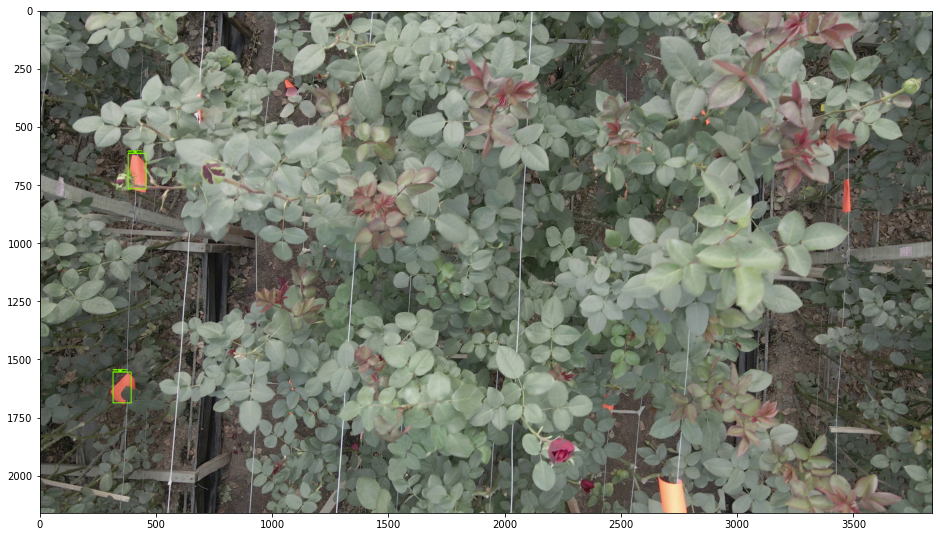

In [11]:
for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis, ...]

  # run detections
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))

  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections
  
  # detection_classes should be ints
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()
  label_id_offset = 1
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=20,
      min_score_thresh=.50,
      agnostic_mode=False)
  plt.figure(figsize=(16, 20))
  plt.imshow(image_np_with_detections)
  # analyze only one image
  break
plt.show()

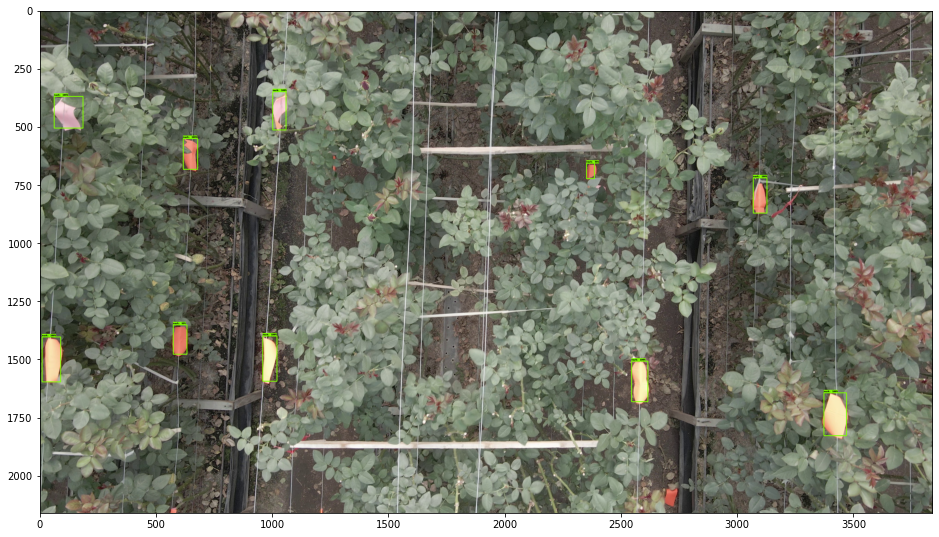

In [39]:
image_name = 'img_57.jpg'
image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# run detections
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()
label_id_offset = 1
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=20,
    min_score_thresh=.50,
    agnostic_mode=False)
plt.figure(figsize=(16, 20))
plt.imshow(image_np_with_detections)
plt.show()

## Analyze 'Y' distance

In [40]:
def euclidian_distance(p1, p2):
  return round(((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)**0.5, 1)

def y_distance(p1, p2):
  return abs(p2[1] - p1[1])

def get_centroid(coords):
  ymin, xmin, ymax, xmax = coords
  x_ = (xmin + xmax) / 2
  y_ = (ymin + ymax) / 2
  return (x_, y_)

In [41]:
min_score_thresh = .5
h, w, _ = image_np.shape
y_ = []

for idx, score in enumerate(detections['detection_scores']):
  if score >= min_score_thresh:
    ymin, xmin, ymax, xmax = detections['detection_boxes'][idx]
    ymin, xmin, ymax, xmax = int(ymin * h), int(xmin * w), int(ymax * h), int(xmax * w)
    y_.append((ymin + ymax) / 2)

In [42]:
len(y_)

10

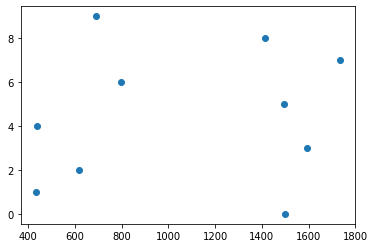

In [43]:
plt.scatter(y_, range(len(y_)))

## Clustering

In [44]:
from sklearn.cluster import KMeans

In [54]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
fitted = False
try:
  kmeans.fit(np.array(y_).reshape(-1, 1))
  fitted = True
except:
  print('Not possible to create clusters')

In [115]:
lines = []
if fitted:
  print('labels:', kmeans.labels_)

  cnt_dict = {}

  counter = np.unique(kmeans.labels_, return_counts=True)
  for key, ctr in zip(counter[0], counter[1]):
    cnt_dict[key] = ctr
  print('cnt_dict:', cnt_dict)
  
  for key in cnt_dict.keys():
    if cnt_dict[key] > 1:
      lines.append(int(kmeans.cluster_centers_.reshape(-1)[key]))
  print('lines:', lines)

labels: [1 2 0 1 2 1 0 1 1 0]
cnt_dict: {0: 3, 1: 5, 2: 2}
lines: [701, 1548, 435]


## Draw lines

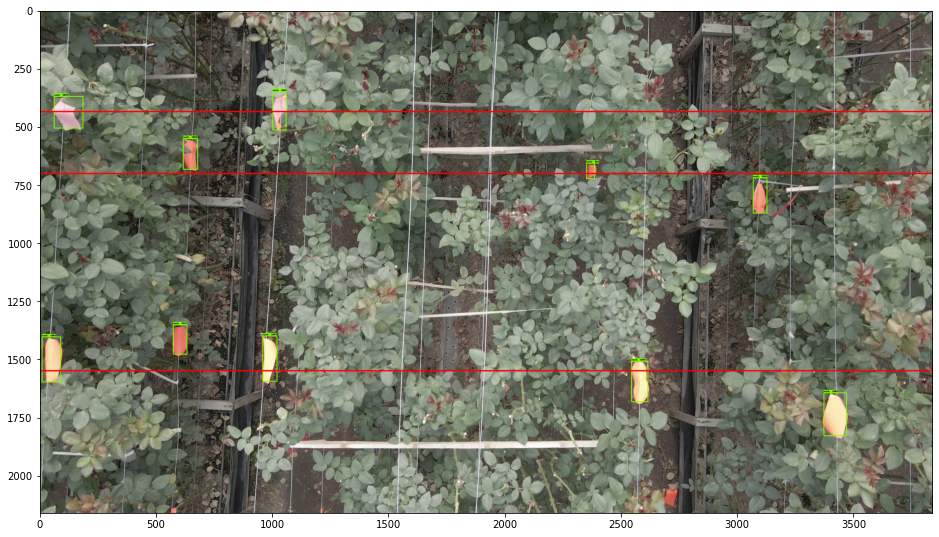

In [116]:
img = Image.fromarray(image_np_with_detections.copy(), 'RGB')
draw = ImageDraw.Draw(img)

for limit in lines:
  draw.line([(0, limit), (w, limit)], width=6, fill='red')
plt.figure(figsize=(16, 20))
plt.imshow(img)
plt.show()

## Check clusters

In [132]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [157]:
best_n_clusters = None
cluster_score = None
for idx, n_clusters in enumerate(range(2, 4)):
  kmeans = KMeans(n_clusters=n_clusters)
  kmeans.fit(np.array(y_).reshape(-1, 1))
  silhouette_avg = silhouette_score(np.array(y_).reshape(-1, 1), kmeans.predict(np.array(y_).reshape(-1, 1)))
  print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
  if idx == 0 or cluster_score < silhouette_avg:
    best_n_clusters = n_clusters
    cluster_score = silhouette_avg
print('Best number of clusters is {} with score {}'.format(best_n_clusters, cluster_score))

For n_clusters = 2 The average silhouette_score is : 0.8168345775900837
For n_clusters = 3 The average silhouette_score is : 0.7651569555124242
Best number of clusters is 2 with score 0.8168345775900837


In [158]:
n_clusters = best_n_clusters
kmeans = KMeans(n_clusters=n_clusters)
fitted = False
try:
  kmeans.fit(np.array(y_).reshape(-1, 1))
  fitted = True
except:
  print('Not possible to create clusters')

In [159]:
lines = []
if fitted:
  print('labels:', kmeans.labels_)

  cnt_dict = {}

  counter = np.unique(kmeans.labels_, return_counts=True)
  for key, ctr in zip(counter[0], counter[1]):
    cnt_dict[key] = ctr
  print('cnt_dict:', cnt_dict)
  
  for key in cnt_dict.keys():
    if cnt_dict[key] > 1:
      lines.append(int(kmeans.cluster_centers_.reshape(-1)[key]))
  print('lines:', lines)

labels: [1 0 0 1 0 1 0 1 1 0]
cnt_dict: {0: 5, 1: 5}
lines: [595, 1548]


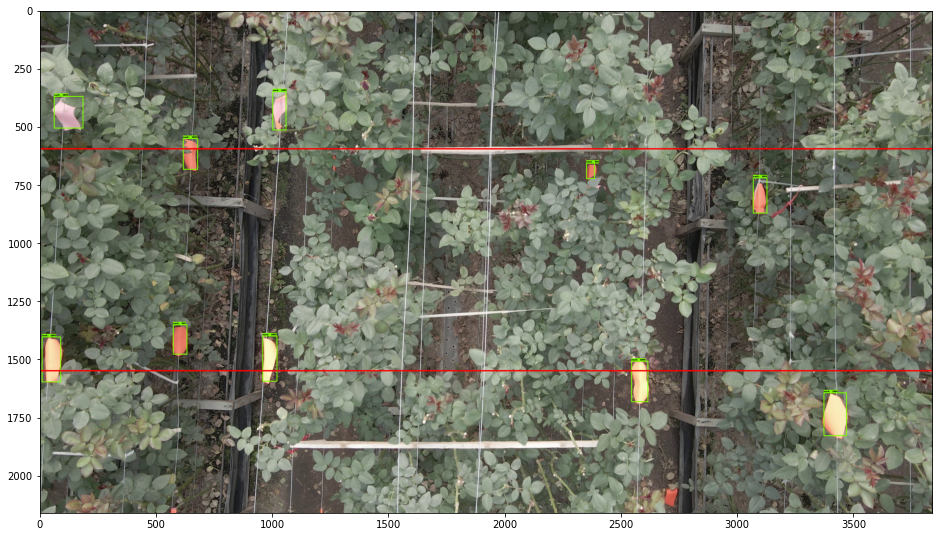

In [160]:
img = Image.fromarray(image_np_with_detections.copy(), 'RGB')
draw = ImageDraw.Draw(img)

for limit in lines:
  draw.line([(0, limit), (w, limit)], width=6, fill='red')
plt.figure(figsize=(16, 20))
plt.imshow(img)
plt.show()